In [2]:
import cdflib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
from datetime import datetime

from cdfReader import extractDF

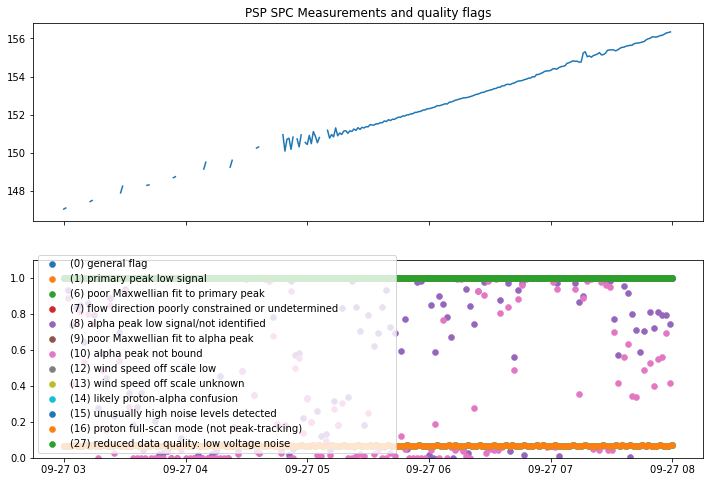

In [2]:
cdfPath = "/home/diegodp/Documents/PhD/Paper_2/InsituEMDCorrelation/unsafe/Resources/PSP_Data/SWEAP/psp_swp_spc_l3i_20200927_v02.cdf"

def readPlotPSPErrors(cdfPath, altSpeed = "vp_moment_RTN"):
	df = pd.DataFrame({})
	cdf = cdflib.CDF(cdfPath)
	t = cdflib.cdfepoch().to_datetime(cdf["Epoch"])
	for i, label in enumerate(["R", "T", "N"]):
		df["V_" + str(label)] = cdf[altSpeed][:, i]
	
	df2 = pd.DataFrame({}, index=t)
	
	for i, flagName in enumerate(cdf["DQF_FLAGNAMES"][0]):
		df2[str(flagName)] = cdf["DQF"][:,i]

	# Build figure
	fig, axs = plt.subplots(2,1, figsize=(12,8), sharex=True)
	df["flag"] = cdf["general_flag"]
	df.index = t
	df[df["V_R"] < 0] = np.nan 
	df = df[datetime(2020, 9, 27, 3): datetime(2020,9,27,8)]
	df = df.resample("60s").mean()

	df2 = df2.resample("60s").mean()
	df2 = df2[datetime(2020, 9, 27, 3): datetime(2020,9,27,8)]
	axs[0].plot(df["V_R"])

	for flagName in cdf["DQF_FLAGNAMES"][0]:
		if 1 in df2[str(flagName)].values:
			axs[1].scatter(df2.index, df2[str(flagName)], label=str(flagName), linewidth=0.5)
		
	plt.ylim(0, 1.1)
	plt.legend()
	axs[0].set_title("PSP SPC Measurements and quality flags")
	plt.savefig(f"/home/diegodp/Documents/PhD/Paper_2/InsituEMDCorrelation/Figures/PSP_SPC_errors.png", facecolor=fig.get_facecolor(), edgecolor='none')
	plt.show()

cdf = readPlotPSPErrors(cdfPath)

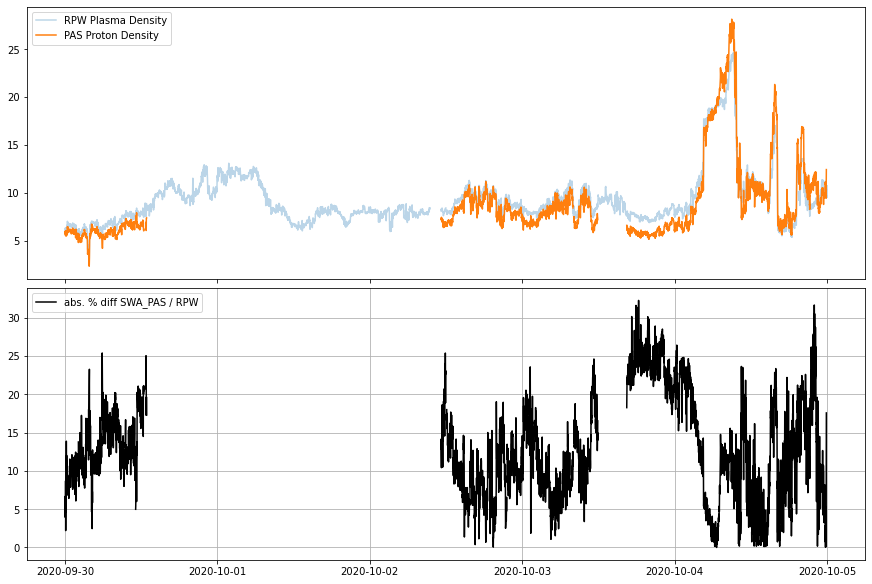

In [3]:
folderRPW = "/home/diegodp/Documents/PhD/Paper_2/InsituEMDCorrelation/unsafe/Resources/Solo_Data/L3/RPW/"
folderSWEAP = "/home/diegodp/Documents/PhD/Paper_2/InsituEMDCorrelation/unsafe/Resources/Solo_Data/L2/GroundMom/"


# SolO
# Cadence
# resample = False
resample = "60s"

# Get RPW density
_dfDensRPW = extractDF(folderRPW, ["DENSITY"], resample=resample)
# Get SWEAP Density
_dfDensSWEAP = extractDF(folderSWEAP, ["N"], resample=resample)

fig, axs = plt.subplots(2,1, figsize=(12, 8), sharex=True, constrained_layout=True)
_dfDensRPW[_dfDensRPW["DENSITY"] < 0] = np.nan
_dfDensRPW = _dfDensRPW[datetime(2020, 9, 30): datetime(2020, 10, 5)]
_dfDensSWEAP = _dfDensSWEAP[datetime(2020, 9, 30): datetime(2020, 10, 5)]

a, b = _dfDensSWEAP["N"], _dfDensRPW["DENSITY"]
diff = 100*(np.abs(a-b) / ((a+b) / 2))

axs[0].plot(_dfDensRPW["DENSITY"], alpha = 0.3, label="RPW Plasma Density")
axs[0].plot(_dfDensSWEAP["N"], label = "PAS Proton Density")
axs[0].legend()

axs[1].plot(diff, label="abs. % diff SWA_PAS / RPW", color="black")
# axs[1].plot(diff.index, np.repeat(1, len(diff.index)), linestyle="--", color="black")
axs[1].grid(True)
axs[1].legend()

plt.savefig("/home/diegodp/Documents/PhD/Paper_2/InsituEMDCorrelation/Figures/SolODataAvail.png")
plt.show()


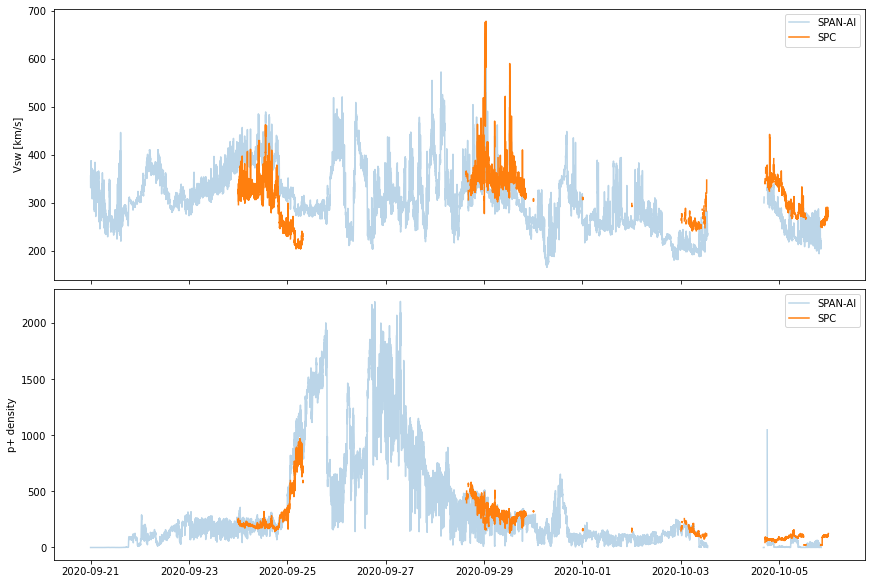

In [5]:
folderPSP_SPC = "/home/diegodp/Documents/PhD/Paper_2/InsituEMDCorrelation/unsafe/Resources/PSP_Data/SWEAP/"
folderPSP_ANAI= "/home/diegodp/Documents/PhD/Paper_2/InsituEMDCorrelation/unsafe/Resources/PSP_Data/SWEAP/SPAN-AI/"

# TODO: Check that the coordinate system is RTN or can be converted
# TODO: Check what other variables are relevant
dfPSP_ANAI = extractDF(folderPSP_ANAI, ["DENS", "VEL"], info=False)
dfPSP_SPC = extractDF(folderPSP_SPC, ["vp_moment_RTN", "general_flag", "np_moment"], info=False)

# Figure
fig, axs = plt.subplots(2,1, figsize=(12,8), sharex=True, constrained_layout=True)


dfPSP_ANAI = dfPSP_ANAI.resample("60s").mean()
dfPSP_ANAI[dfPSP_ANAI["V_R"] > 400] = np.nan

dfPSP_SPC = dfPSP_SPC.resample("60s").mean()
dfPSP_SPC[dfPSP_SPC["V_R"] < 0 ]= np.nan
dfPSP_SPC[dfPSP_SPC["np_moment"] < 0 ]= np.nan

axs[0].plot(- dfPSP_ANAI["V_R"], label = "SPAN-AI", alpha = 0.3)
axs[0].plot(dfPSP_SPC["V_R"], label = "SPC")
axs[0].set_ylabel("Vsw [km/s]")
axs[0].legend()

axs[1].plot(dfPSP_ANAI["DENS"], label="SPAN-AI", alpha=0.3)
axs[1].plot(dfPSP_SPC["np_moment"], label = "SPC")
axs[1].set_ylabel("p+ density")
axs[1].legend()

plt.savefig("/home/diegodp/Documents/PhD/Paper_2/InsituEMDCorrelation/Figures/PSPDataAvail.png")
plt.show()